Make sure you deleted all old version of `dynamo` and installed the newest one from github. The version I used to generate this tutorial is `0.0+89e5bb9.dirty` (see below). `dynamo` is still under active development, but it will be submitted to `PyPi` in one month or so. 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import dynamo as dyn
dyn.__version__

'0.0+1ed7a32'

## Dynamo supports a variety of experimental setups

| Experiment type | Estimation method | Description (has splicing data) | Description (no splicing data) | Parameters suitable to estimate |
| --- | --- | --- | --- | --- |
| Kinetics: <br> multiple time point labeling; <br> lasts several hours | stochastic (moment equations) | using first/second moments of $uu, ul, su, sl$ (`unspliced unlabeled`, `unspliced labeled`, `spliced unlabled`, `spliced labeled`) to estimate $\alpha, \beta, \gamma$ (`transcription`, `splicing` and `degradataion rate`) jointly.| using first/second moments of $U (uu + su), L (ul + sl) $ (`Unlabeled` or `labeled`) to estimate $\alpha, \gamma$ jointly.| $\beta, \gamma$ |
| Kinetics: <br> multiple time point labeling; <br> lasts several hours  | deterministic (ODEs) | 1. use $uu$ over $t$ (time) to estimate $\beta$ <br> 2. use the estimated $\beta$ and $ul$ over $t$ to estimate $\alpha$. 3. use the estimated $\beta$ and $uu, su$ over $t$ to estimate $\gamma$ <br> | 1. use $U$ over $t$ to estimate $\gamma$. <br> 2. use the estimated $\gamma$ and $L$ over $t$ to estimate $\alpha$. | $\beta, \alpha$ |
| one-shot: <br> single time point labeling; <br> short time | deterministic (ODEs) | a. if $\beta, \gamma$ are already estimated by a degradation experiment, $\alpha$ is estimated by $ul$ over $t$ and $\beta$. <br> b. if $\beta, \gamma$ are not estimated, use $uu$ over $t$ to solve for $\beta$ first and then the solved $\beta$ and the $uu$ over $t$ to solve for $\alpha$. | a. if $\gamma$ are already estimated by a degradation experiment, $\alpha$ is estimated by $L$ over $t$ and the estimated $\gamma$. <br> b. if $\gamma$ are not estimated, use $U$ over $t$ to solve for $\gamma$ first and then the solved $\gamma$ and the $L$ over $t$ to solve for $\alpha$.  | $\alpha$.  |
| degradation: <br> pulse-chase; <br> can chase more than 1 day | deterministic (ODEs)| 1. use $ul$ over $t$ to estimate $\beta$, the estimated $\beta$ and $ul, sl$ over $t$ to estimate $\gamma$. <br> 2. use the estimated $\beta$ and $uu$ over $t$ to estimate $\alpha$. | 1. use $L$ over $t$ to estimate $\gamma$ <br> 2. use $U$ over $t$ to estimate $\alpha$ | $\gamma$ |
| no metabolic labeling: <br> regular scRNA-seq data | steady state assumption: $\frac{ds}{dt} = \beta u - \gamma s = 0$ | assume $\beta$ is 1 and then estimate $\gamma$ by using extreme data points of $u$ (`unspliced mRNA`) and $s$ (`spliced mRNA`). | None | All parameters are relative |
| cite-seq/reap-seq, etc: <br> RNA/protein coassay | steady state assumption: $\frac{dp}{dt} = \eta s - \delta s = 0$ | assume $\eta$ is 1 and then estimate $\delta$ by using extreme data points of $s$ (`spliced mRNA`) and $p$ (`protein`). | None | All parameters are relative |

for details related to moment equations, see the full derivation here: https://github.com/aristoteleo/dynamo-notebooks/blob/master/full_derivation.pdf <br>
for details related to others strategies, see the https://github.com/aristoteleo/dynamo-notebooks/blob/master/velocity_demo/dynamo_fitting_demo.ipynb 
    

We used Gillespie simulation to simulate the cell fate bifurcation. Details can be refered to `supplementary figure 1` of our preprint (https://www.biorxiv.org/content/10.1101/696724v1.full). 

<img src="https://www.biorxiv.org/content/biorxiv/early/2019/07/09/696724/F3.large.jpg?width=800&height=600&carousel=1" width="400">

We first simulate cells to achieve a progenitor steady state. Then we simulate the bifurcation of cell fates into different terminal cell states because of drug treatment or external signals. Next we simulate a metabolic labeling experiment and synthesize kinetics experiment data at each checkpoint. Finally, we stimulate a degradation experiment at the begining or end of the cell differentiation experiment. This setup is typical for a labeling experiment. 


In [2]:
# Gillespie simulation of a regular labeling experiment for a cell fate bifurcation process. 

adata_dif, adata_dif_nosplicing = dyn.sim.Gillespie(method='differentiation', verbose=False)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [3]:
# Now let get the kinetics experiment data at check point t_5, the degradation experiment at the beginning or the end of the differentiation process. 

adata_dif_kin, adata_dif_deg_begin, adata_dif_deg_end = adata_dif[adata_dif.obs.experiment_type == 'kin_t_5', :], \
                                                        adata_dif[adata_dif.obs.experiment_type == 'deg_beign', :], \
                                                        adata_dif[adata_dif.obs.experiment_type == 'deg_end', :]

/home/xqiu/.local/lib/python3.6/site-packages/dynamo/tools/dynamics.py:159: UserWarning: protein layer exists but protein_names is not provided. No estimation will be performed for protein data.
  'protein layer exists but protein_names is not provided. No estimation will be performed for protein data.')
/home/xqiu/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


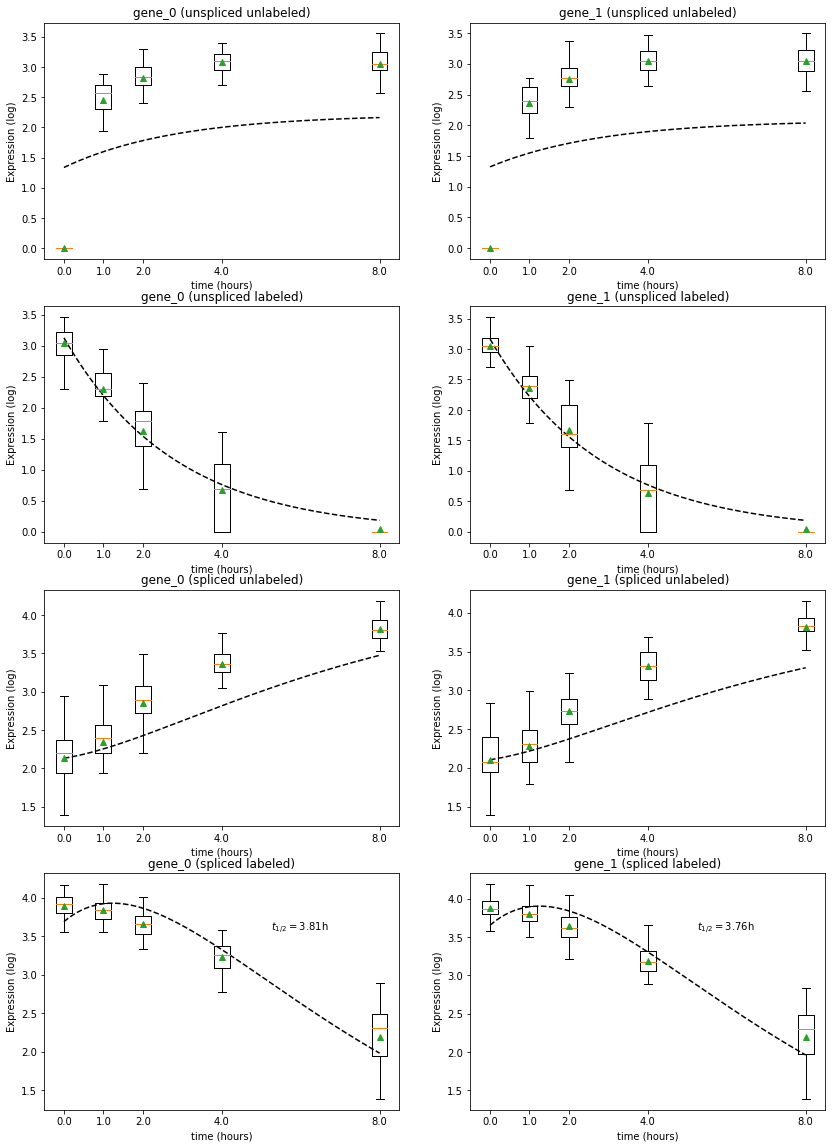

In [4]:
# Let us show Dynamo's fitting for the beginning of a degradation experiment

adata_dif_deg_begin = dyn.tl.dynamics(adata_dif_deg_begin, experiment_type='deg', filter_gene_mode='no', tkey='time')
dyn.pl.dynamics(adata_dif_deg_begin, vkey=adata_dif_deg_begin.var_names, unit='hours')


from above, we can see that the fitting for `ul` and `sl` are very good but the fitting for `uu` and `su` are not as good. This is because degradation experiment is ideal for estimating $\gamma$ and $\beta$. Note that in real experiments, degradation experiment will chase for up to one day or more, while $\beta$ is often related to just a few minutes so in order to enable accurate $\beta$ estimation, the degradation experiment may need to include a fast labeling period at the beginning, for example including labeling period that separate by just a few minutes or so. 

Trying to set attribute `.uns` of view, making a copy.


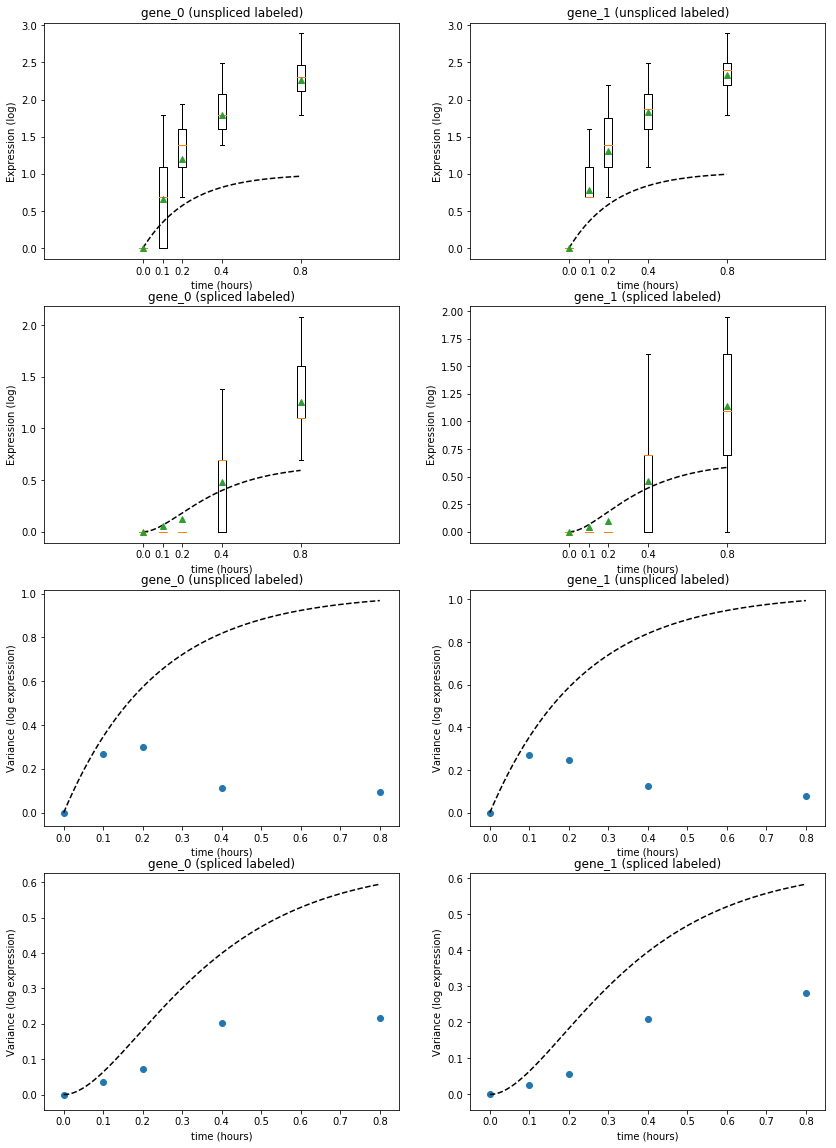

In [5]:
# moment model aims to learn all parameters jointly and also tries to estimate the RNA bursting related parameters, $a, b, \alpha_i, \alpha_a$. See  https://github.com/aristoteleo/dynamo-notebooks/blob/master/full_derivation.pdf.  

adata_dif_kin = dyn.tl.dynamics(adata_dif_kin, mode='moment', filter_gene_mode='no', tkey='time')
dyn.pl.dynamics(adata_dif_kin, vkey=adata_dif_kin.var_names, unit='hours')

/home/xqiu/.local/lib/python3.6/site-packages/dynamo/tools/velocity.py:909: UserWarning: beta & gamma estimation: only works when there're at least 2 time points.
  warn("beta & gamma estimation: only works when there're at least 2 time points.")


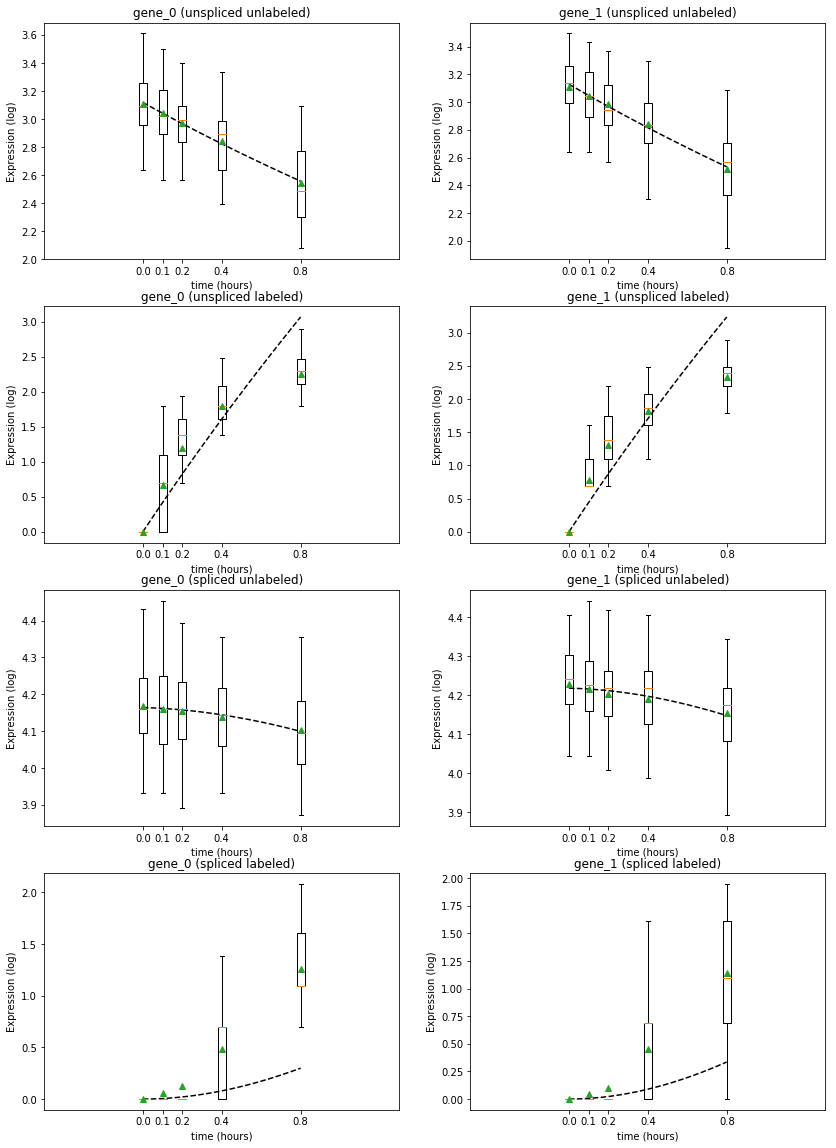

In [6]:
# kinetics: the data for this mode is the same as the moment approach but it uses least sqaure fitting of the determinstic ODE solutions for fitting. 

adata_dif_kin = dyn.tl.dynamics(adata_dif_kin, experiment_type='kin', filter_gene_mode='no', tkey='time')
dyn.pl.dynamics(adata_dif_kin, vkey=adata_dif_kin.var_names, unit='hours')

From above, we can see that the $uu, ul$ fitting are pretty good. This is because the kinetics experiment is good for estimating parameters $\beta, \alpha$. `su` fitting looks good here but in general kinetics experiment only involves at most a few hours, the degradation of mRNA can be up to one or two days, so in pratice the fitting `su` of certain genes in real data may be less optimal. Finally the `sl` fitting is not great, this is because it is involves all parameters $\alpha, \beta, \gamma$ to fit the data and any uncertainty from those parameters can affect the fitting. 

/home/xqiu/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:118: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


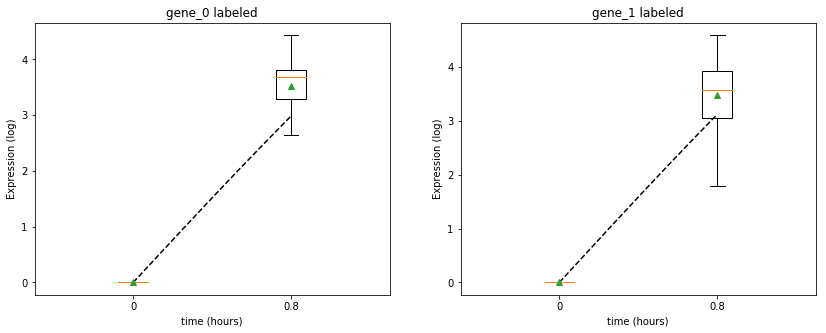

In [7]:
# one_shot. One shot experiment is great for estimating $\alpha$ at different time points, especially if we combined with a degradation experiment and assume constant $\beta, \gamma$ through the entire period. 

tmp = dyn.tl.dynamics(adata_dif_kin[adata_dif_kin.obs.time == 0.8, :], experiment_type='one_shot', filter_gene_mode='no', tkey='time')
dyn.pl.dynamics(tmp, vkey=adata_dif_kin.var_names, unit='hours')


# the following are similar analysis if we don't have splicing data
This is normally true because spliting U to uu, su and L to ul, sl may be difficult especially for some transcription which already have low expression. The discussion above will be generally applicable below but just avoid the consideration of splicing. 

In [8]:
adata_dif_kin_nosplicing, adata_dif_deg_begin_nosplicing, adata_dif_deg_end_nosplicing = adata_dif_nosplicing[adata_dif_nosplicing.obs.experiment_type == 'kin_t_5', :], \
                                                        adata_dif_nosplicing[adata_dif_nosplicing.obs.experiment_type == 'deg_beign', :], \
                                                        adata_dif_nosplicing[adata_dif_nosplicing.obs.experiment_type == 'deg_end', :]



In [9]:
adata_dif_deg_begin_nosplicing

View of AnnData object with n_obs × n_vars = 250 × 2 
    obs: 'trajectory', 'time', 'experiment_type'
    obsm: 'protein'
    layers: 'new', 'total'

/home/xqiu/.local/lib/python3.6/site-packages/dynamo/tools/dynamics.py:159: UserWarning: protein layer exists but protein_names is not provided. No estimation will be performed for protein data.
  'protein layer exists but protein_names is not provided. No estimation will be performed for protein data.')
Trying to set attribute `.var` of view, making a copy.


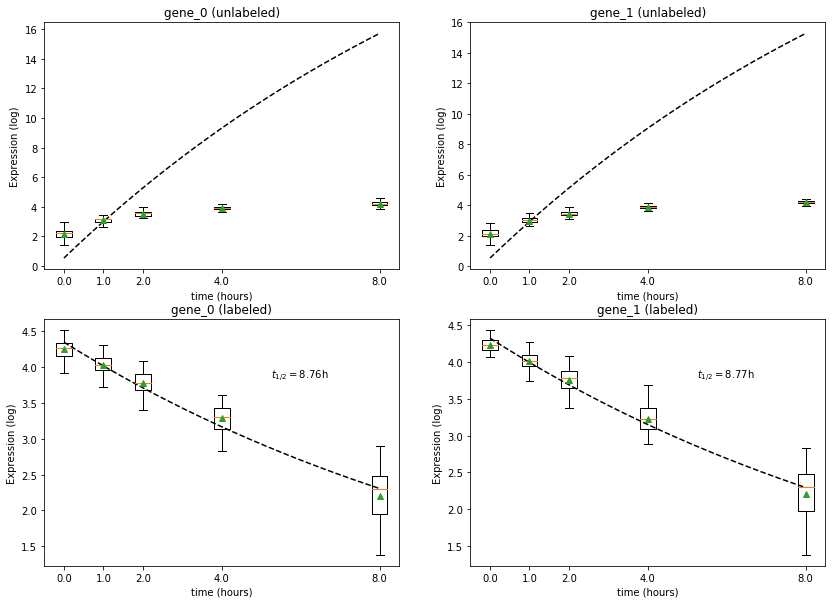

In [10]:
# Degradation
import dynamo as dyn
adata_dif_deg_begin_nosplicing = dyn.tl.dynamics(adata_dif_deg_begin_nosplicing, experiment_type='deg', filter_gene_mode='no', tkey='time')
dyn.pl.dynamics(adata_dif_deg_begin_nosplicing, vkey=adata_dif_deg_begin_nosplicing.var_names, unit='hours')


Trying to set attribute `.uns` of view, making a copy.


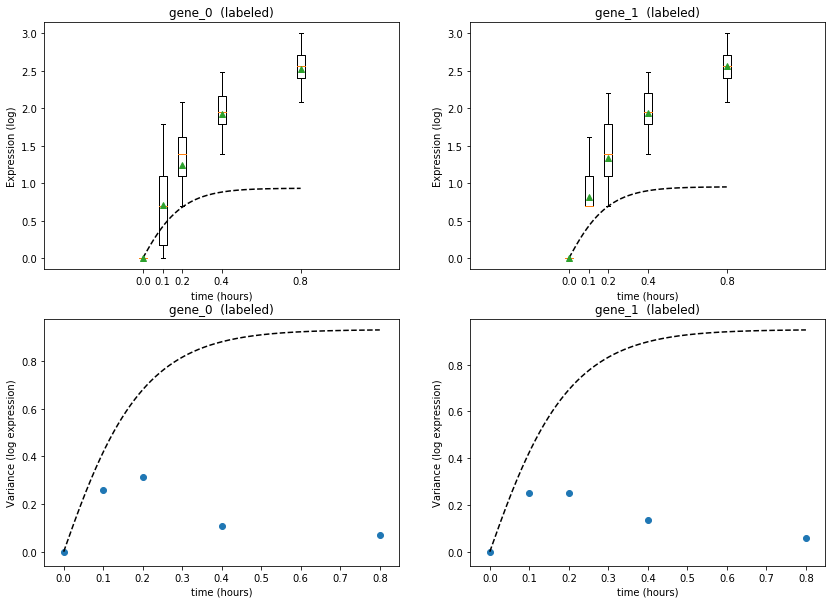

In [11]:

# moment
adata_dif_kin_nosplicing = dyn.tl.dynamics(adata_dif_kin_nosplicing, mode='moment', filter_gene_mode='no', tkey='time')
dyn.pl.dynamics(adata_dif_kin_nosplicing, vkey=adata_dif_kin_nosplicing.var_names, unit='hours')


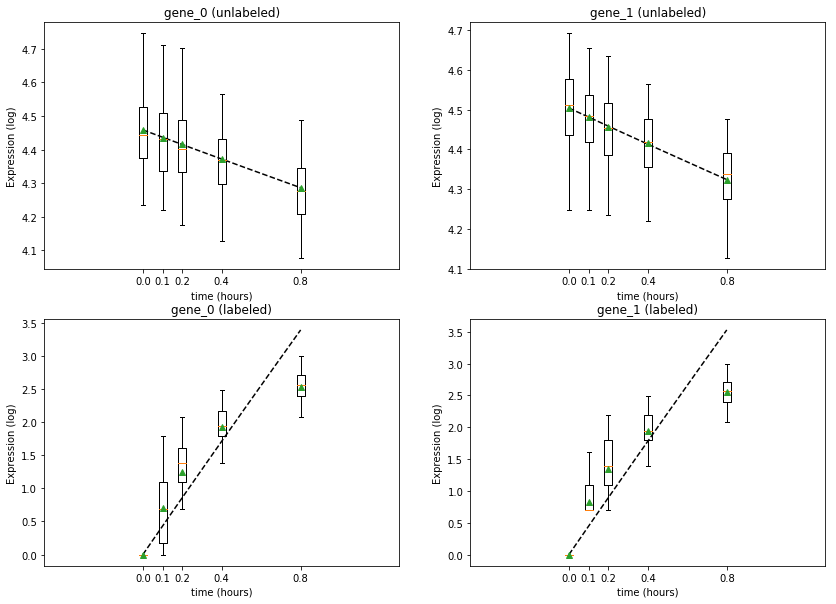

In [12]:
# kinetics
adata_dif_kin_nosplicing = dyn.tl.dynamics(adata_dif_kin_nosplicing, experiment_type='kin', filter_gene_mode='no', tkey='time')
dyn.pl.dynamics(adata_dif_kin_nosplicing, vkey=adata_dif_kin_nosplicing.var_names, unit='hours')


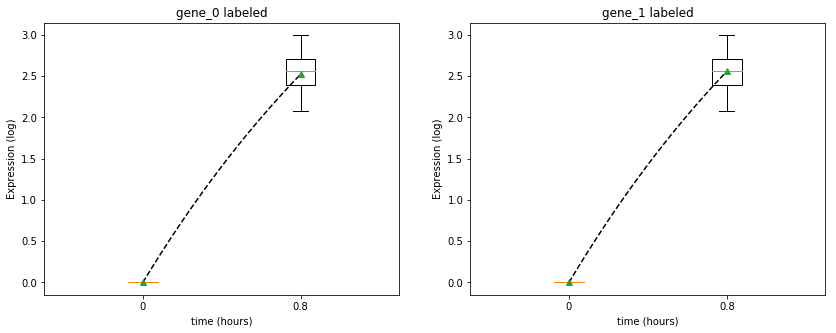

In [13]:

# one_shot
tmp = dyn.tl.dynamics(adata_dif_kin_nosplicing[adata_dif_kin_nosplicing.obs.time == 0.8, :], experiment_type='one_shot', filter_gene_mode='no', tkey='time')
dyn.pl.dynamics(tmp, vkey=adata_dif_kin_nosplicing.var_names, unit='hours')
